### Setup Environment:

In [1]:
from src.get_dataset import split_data
from src.data_loader import BRSETDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/home/opc/Retina/BRSET/'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'images/')
LABEL = 'patient_sex'
TEST_SIZE = 0.7
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'image_id'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = None # [0.485, 0.456, 0.406]
NORM_STD = None # [0.229, 0.224, 0.225]

BACKBONE = 'convnextv2_base'
MODE = 'fine_tune'
backbone_mode = 'eval'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 16
NUM_WORKERS = 4

LOSS = None #'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 5e-6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [3]:
df_train = pd.read_csv(os.path.join(DATASET, 'train_ssl.csv'))
df_test = pd.read_csv(os.path.join(DATASET, 'test_ssl.csv'))

In [4]:
# Map values to categories
df_train[LABEL] = df_train[LABEL].apply(lambda x: 'Male' if x == 1 else 'Female')
df_test[LABEL] = df_test[LABEL].apply(lambda x: 'Male' if x == 1 else 'Female')

Getting validation set...
Train data shape: (5205, 35)
Test data shape: (1302, 35)


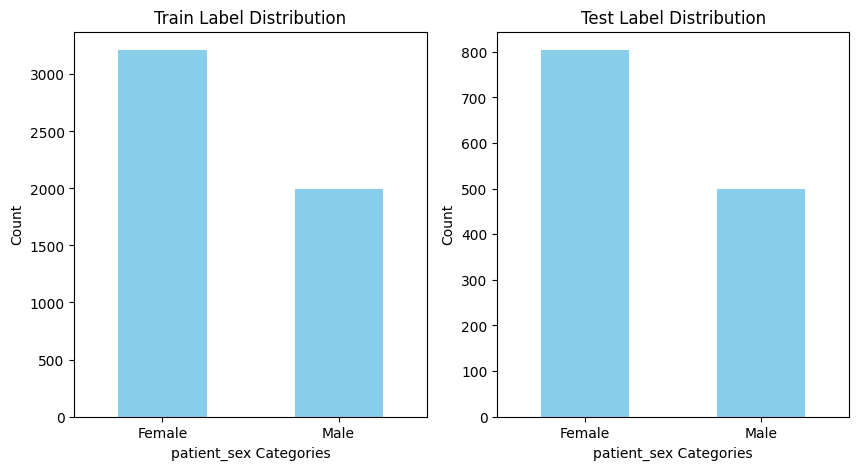

In [5]:
# Split dataset into train, test and validation:
#df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_test, df_val = split_data(df_test, LABEL, 0.20)

### Dataloaders

In [6]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [7]:
# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [8]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

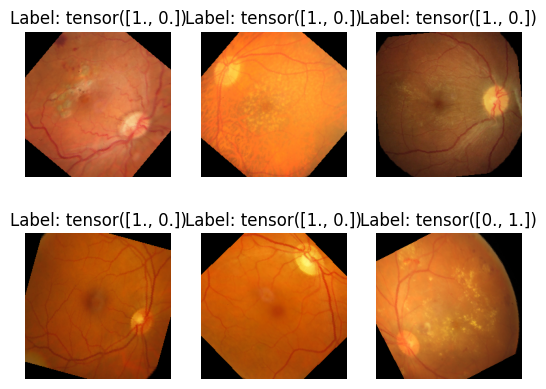

In [9]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [10]:
# Create the model
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
# Load backbone weights:
backbone_model.load_state_dict(torch.load('Models/checkpoint_convnextv2_base_byol.pt'))
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Using 2 GPUs!


### Training:

In [11]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [12]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone=f'convnextv2_binary_{LABEL}_byol')

100%|██████████| 82/82 [00:23<00:00,  3.52it/s]


Epoch 1, Train Loss: 0.717095279595891, Val Loss: 0.6882119520408351, F1 Score: 0.522507068580014


100%|██████████| 82/82 [00:23<00:00,  3.45it/s]


Epoch 2, Train Loss: 0.7140366931919192, Val Loss: 0.7002979851350551, F1 Score: 0.49997045790251105


100%|██████████| 82/82 [00:23<00:00,  3.48it/s]


Epoch 3, Train Loss: 0.7029555836173355, Val Loss: 0.6864739402038295, F1 Score: 0.5571094116200499


100%|██████████| 82/82 [00:23<00:00,  3.50it/s]


Epoch 4, Train Loss: 0.6974889017519403, Val Loss: 0.6860662073623843, F1 Score: 0.5840223307601564


100%|██████████| 82/82 [00:23<00:00,  3.45it/s]


Epoch 5, Train Loss: 0.6773759784757114, Val Loss: 0.6677151315095948, F1 Score: 0.6064634055900432


100%|██████████| 82/82 [00:23<00:00,  3.54it/s]


Epoch 6, Train Loss: 0.6452364038248531, Val Loss: 0.629146851054052, F1 Score: 0.651472366414448


100%|██████████| 82/82 [00:23<00:00,  3.50it/s]


Epoch 7, Train Loss: 0.622375139398653, Val Loss: 0.8432678852866335, F1 Score: 0.5498637235195829


100%|██████████| 82/82 [00:23<00:00,  3.54it/s]


Epoch 8, Train Loss: 0.616892561658484, Val Loss: 0.682786547919599, F1 Score: 0.6154527733475101


100%|██████████| 82/82 [00:23<00:00,  3.43it/s]


Epoch 9, Train Loss: 0.5931537604722821, Val Loss: 0.6216781252041096, F1 Score: 0.697564835613641


100%|██████████| 82/82 [00:23<00:00,  3.56it/s]


Epoch 10, Train Loss: 0.5812220095611009, Val Loss: 0.5839942730054622, F1 Score: 0.7025072902467742


100%|██████████| 82/82 [00:23<00:00,  3.56it/s]


Epoch 11, Train Loss: 0.5568744368729044, Val Loss: 0.590815296623765, F1 Score: 0.6688487228981358


100%|██████████| 82/82 [00:23<00:00,  3.45it/s]


Epoch 12, Train Loss: 0.5425105503836616, Val Loss: 0.5631595557419266, F1 Score: 0.7011740746385764


100%|██████████| 82/82 [00:22<00:00,  3.58it/s]


Epoch 13, Train Loss: 0.5325538718798122, Val Loss: 0.6416018537995292, F1 Score: 0.687877449510039


100%|██████████| 82/82 [00:23<00:00,  3.47it/s]


Epoch 14, Train Loss: 0.5259620002547248, Val Loss: 0.5751112774014473, F1 Score: 0.6993336203673681


100%|██████████| 82/82 [00:22<00:00,  3.57it/s]


Epoch 15, Train Loss: 0.507182780421171, Val Loss: 0.5930546518506074, F1 Score: 0.7445439725244098


100%|██████████| 82/82 [00:23<00:00,  3.46it/s]


Epoch 16, Train Loss: 0.4958594513476872, Val Loss: 0.5469339477216325, F1 Score: 0.755356355473604


100%|██████████| 82/82 [00:24<00:00,  3.37it/s]


Epoch 17, Train Loss: 0.49768042508207383, Val Loss: 0.5054628294779033, F1 Score: 0.7633361474878764


100%|██████████| 82/82 [00:23<00:00,  3.51it/s]


Epoch 18, Train Loss: 0.4829943878728835, Val Loss: 0.5615896586237884, F1 Score: 0.7167155425219942


100%|██████████| 82/82 [00:23<00:00,  3.45it/s]


Epoch 19, Train Loss: 0.4737980382364304, Val Loss: 0.5329261620233698, F1 Score: 0.7552752787634937


100%|██████████| 82/82 [00:23<00:00,  3.46it/s]


Epoch 20, Train Loss: 0.4643172963965135, Val Loss: 0.5159246003845843, F1 Score: 0.7605929380613882


100%|██████████| 82/82 [00:23<00:00,  3.44it/s]


Epoch 21, Train Loss: 0.4532323211431503, Val Loss: 0.6169869834330024, F1 Score: 0.703991818032843


100%|██████████| 82/82 [00:23<00:00,  3.42it/s]


Epoch 22, Train Loss: 0.4516311029918858, Val Loss: 0.5067551245049733, F1 Score: 0.767386050599111


100%|██████████| 82/82 [00:23<00:00,  3.55it/s]


Epoch 23, Train Loss: 0.4429110924972863, Val Loss: 0.5172124694033366, F1 Score: 0.7586480937344257


100%|██████████| 82/82 [00:23<00:00,  3.48it/s]


Epoch 24, Train Loss: 0.42427134676302064, Val Loss: 0.49516920036659007, F1 Score: 0.7798663324979115


100%|██████████| 82/82 [00:23<00:00,  3.44it/s]


Epoch 25, Train Loss: 0.4293310463550638, Val Loss: 0.5810777524985918, F1 Score: 0.771454707278481


100%|██████████| 82/82 [00:23<00:00,  3.52it/s]


Epoch 26, Train Loss: 0.41306570772020546, Val Loss: 0.4888520424322384, F1 Score: 0.7848823461126708


100%|██████████| 82/82 [00:23<00:00,  3.53it/s]


Epoch 27, Train Loss: 0.4046363895300959, Val Loss: 0.49847090762199425, F1 Score: 0.7745932818352059


100%|██████████| 82/82 [00:23<00:00,  3.53it/s]


Epoch 28, Train Loss: 0.40002392686781335, Val Loss: 0.6572045244094802, F1 Score: 0.6528478264339634


100%|██████████| 82/82 [00:23<00:00,  3.46it/s]


Epoch 29, Train Loss: 0.3864721450282902, Val Loss: 0.4803784026241884, F1 Score: 0.7804330824127481


100%|██████████| 82/82 [00:23<00:00,  3.49it/s]


Epoch 30, Train Loss: 0.3818251181699213, Val Loss: 0.5404529669662801, F1 Score: 0.7655504753238513


100%|██████████| 82/82 [00:23<00:00,  3.45it/s]


Epoch 31, Train Loss: 0.36630884533534286, Val Loss: 0.4998163261064669, F1 Score: 0.7939461117115119


100%|██████████| 82/82 [00:23<00:00,  3.49it/s]


Epoch 32, Train Loss: 0.36488501037486265, Val Loss: 0.5140601576464933, F1 Score: 0.7801206873148315


100%|██████████| 82/82 [00:23<00:00,  3.44it/s]


Epoch 33, Train Loss: 0.3496334865444996, Val Loss: 0.5149805778410377, F1 Score: 0.7875073331892426


100%|██████████| 82/82 [00:23<00:00,  3.43it/s]


Epoch 34, Train Loss: 0.33616082183406, Val Loss: 0.516374562026524, F1 Score: 0.7727844025735462


100%|██████████| 82/82 [00:23<00:00,  3.46it/s]


Epoch 35, Train Loss: 0.3461268401292504, Val Loss: 0.542956395301877, F1 Score: 0.7771176541668345


100%|██████████| 82/82 [00:23<00:00,  3.45it/s]


Epoch 36, Train Loss: 0.34383590540192166, Val Loss: 0.5190119876003847, F1 Score: 0.7792885335492359


100%|██████████| 82/82 [00:23<00:00,  3.54it/s]


Epoch 37, Train Loss: 0.3199255233844284, Val Loss: 0.6333483130466647, F1 Score: 0.7069874248223074


100%|██████████| 82/82 [00:23<00:00,  3.49it/s]


Epoch 38, Train Loss: 0.3116339650737946, Val Loss: 0.5267556445991121, F1 Score: 0.7666860642336576
Early stopping triggered.


### Test

  9%|▊         | 28/326 [00:08<00:54,  5.51it/s]

100%|██████████| 326/326 [01:30<00:00,  3.60it/s]


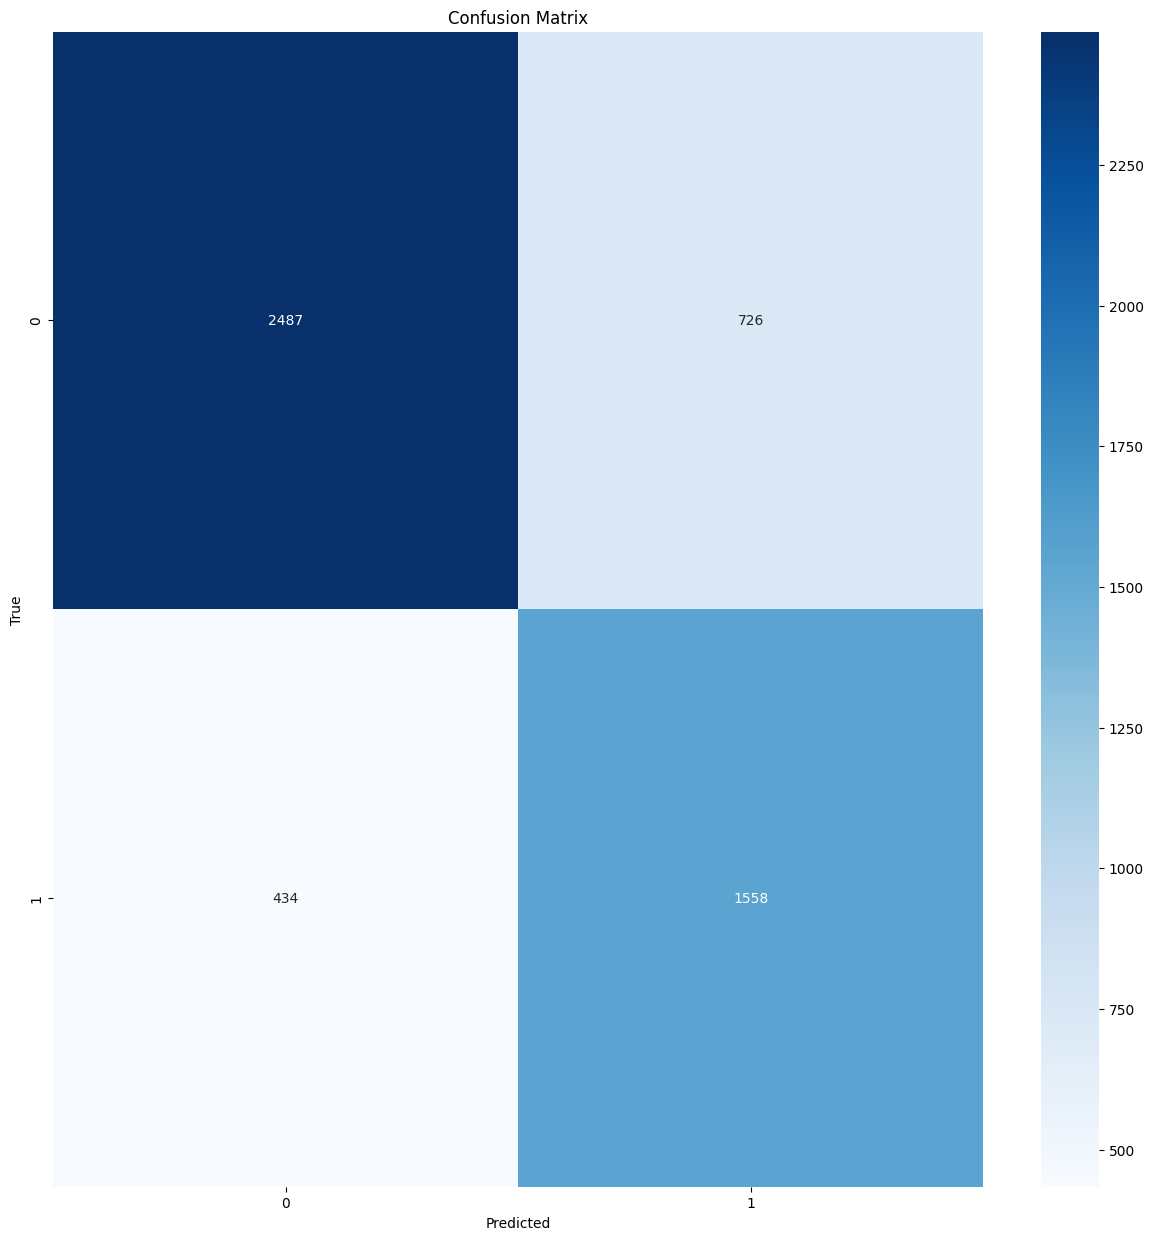

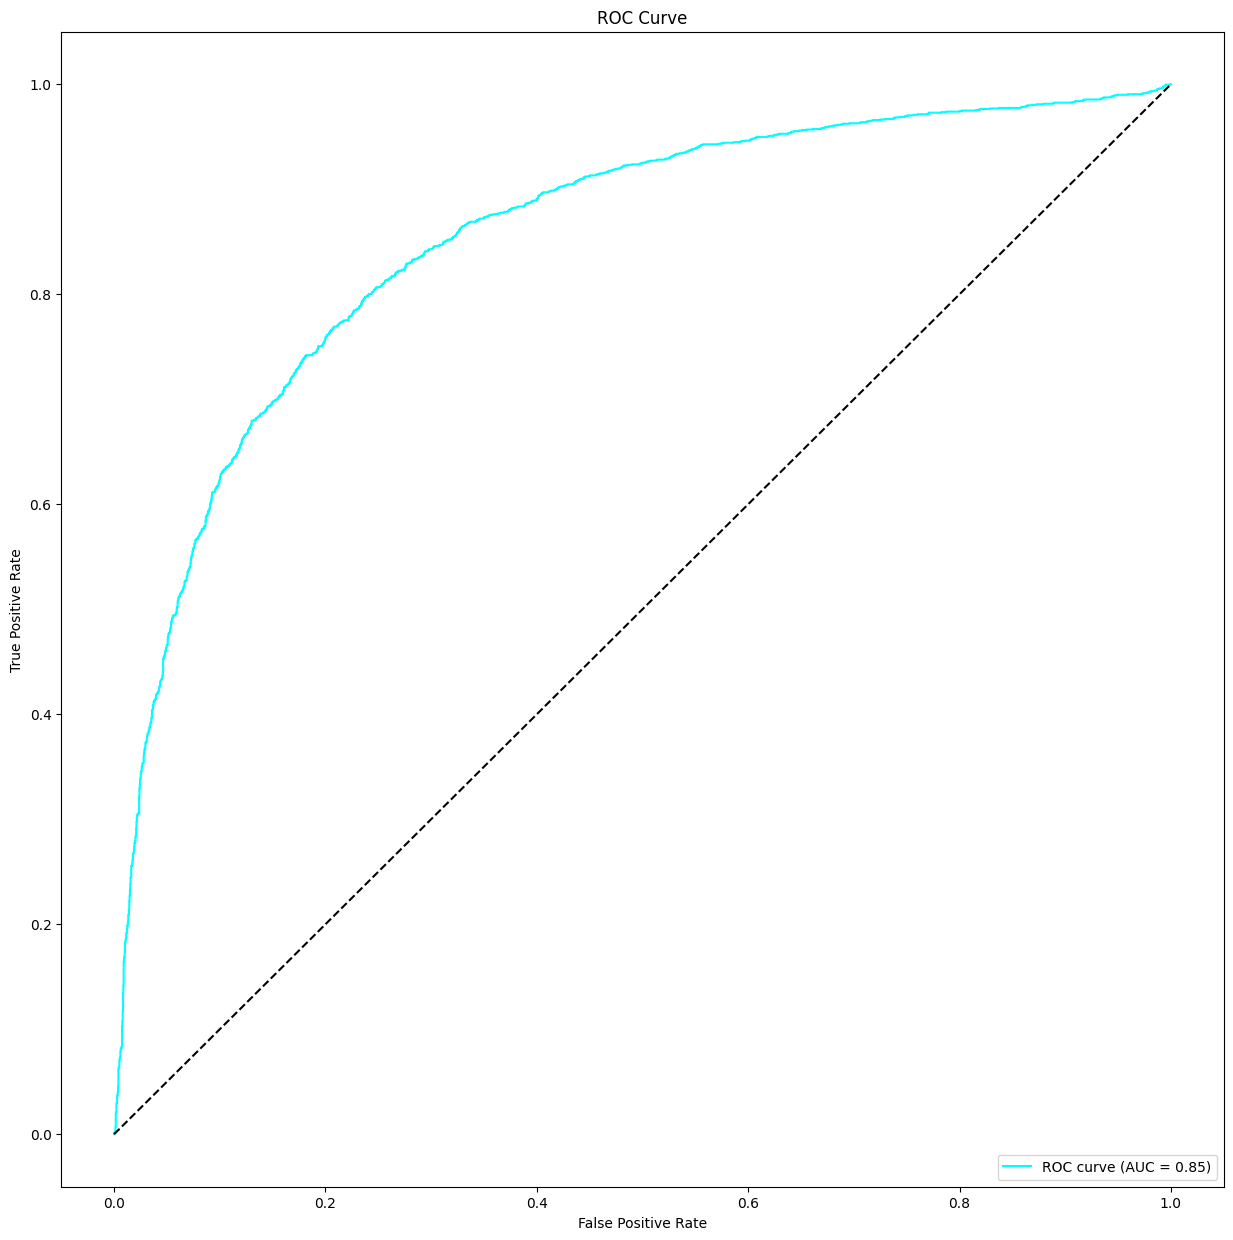

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      3213
           1       0.68      0.78      0.73      1992

    accuracy                           0.78      5205
   macro avg       0.77      0.78      0.77      5205
weighted avg       0.79      0.78      0.78      5205

##################################################  Saliency Maps  ##################################################

Class 0:


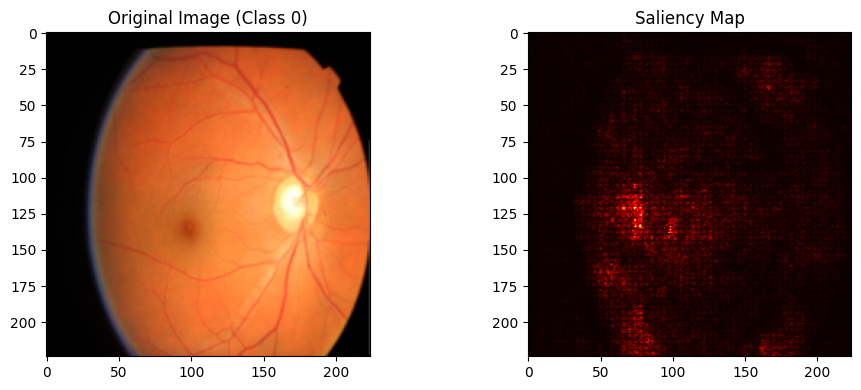

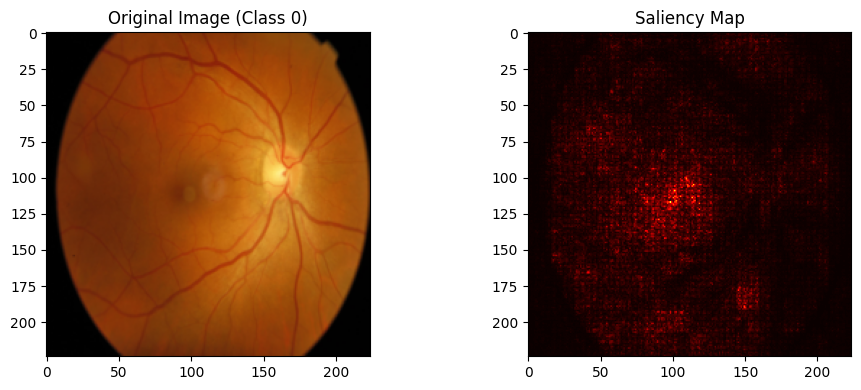

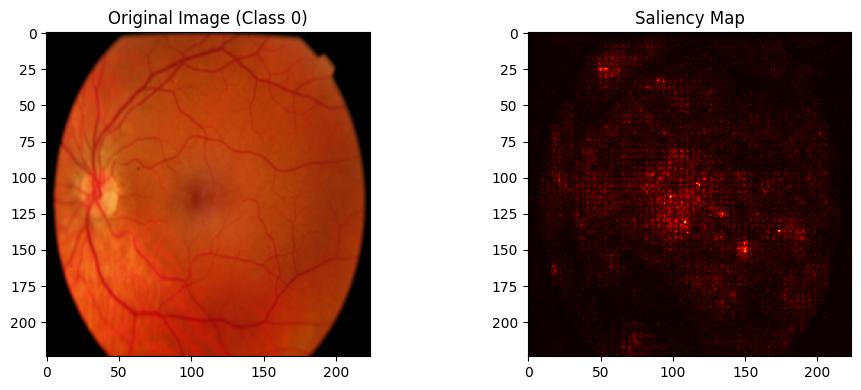

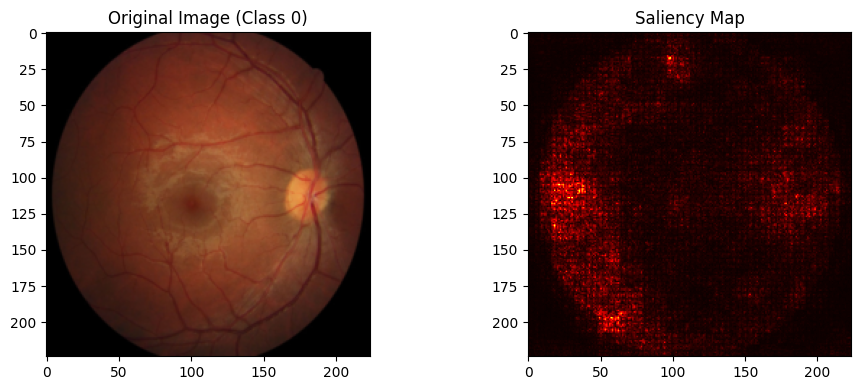

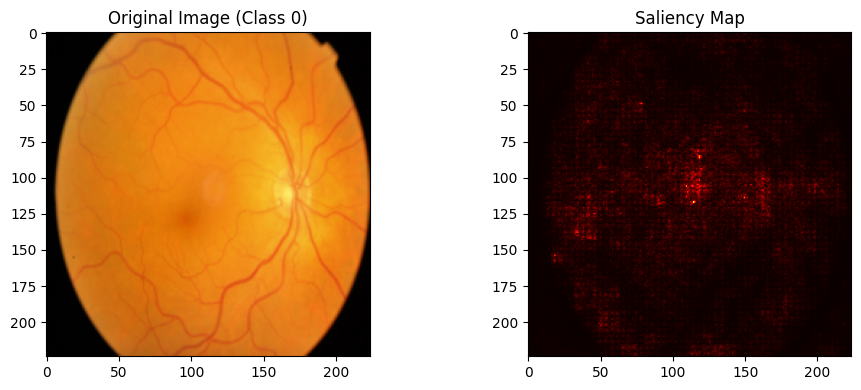

Class 1:


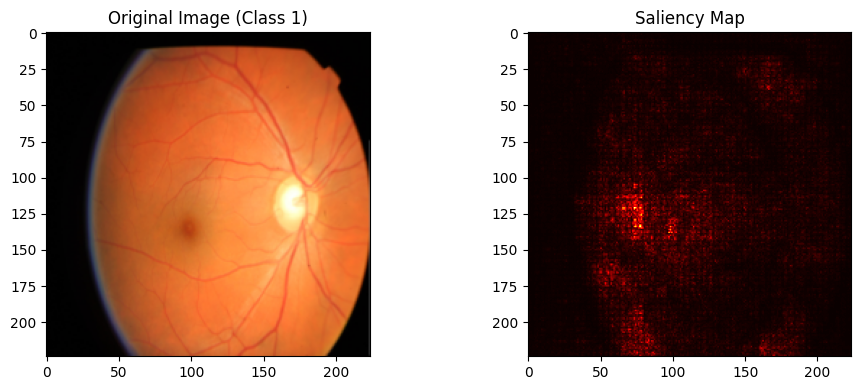

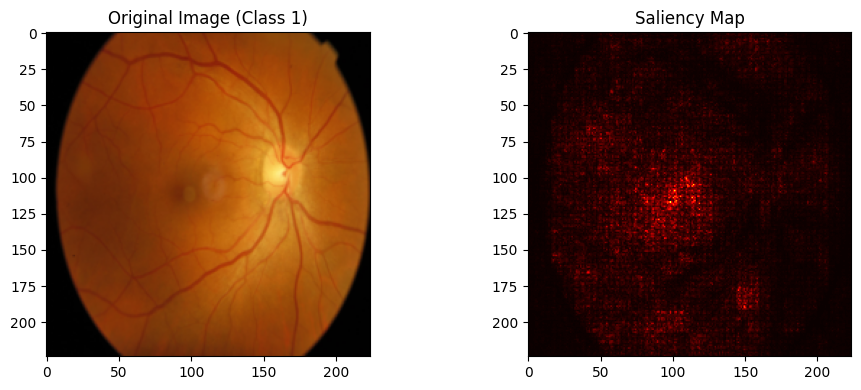

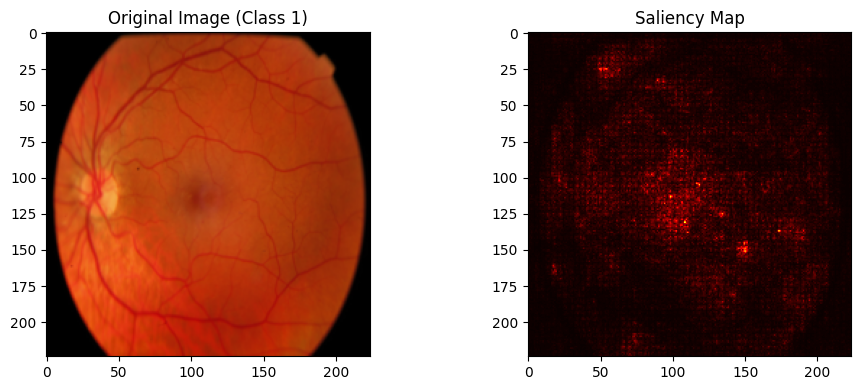

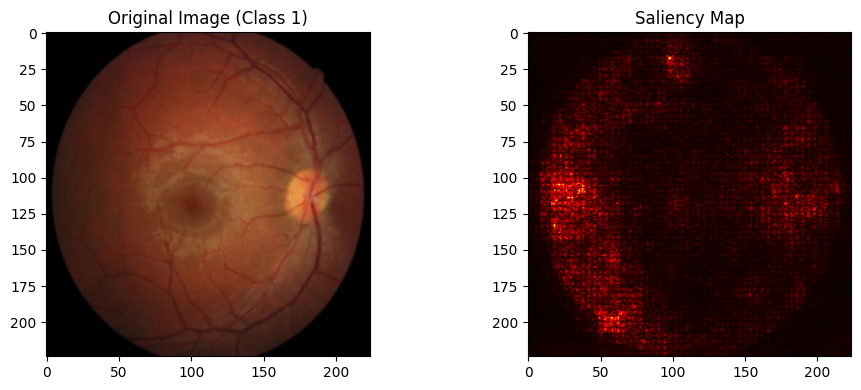

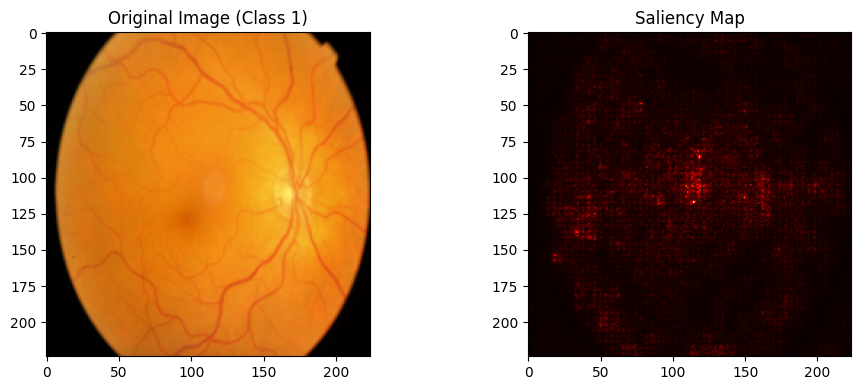

In [13]:
test(model, test_dataloader, saliency=True, device=device)

### Image quality assessment

In [14]:
# Good quality images
adequate_df = df_test[df_test['quality'] == 'Adequate']

# Bad quality images
inadequate_df = df_test[df_test['quality'] == 'Inadequate']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

100%|██████████| 286/286 [01:19<00:00,  3.58it/s]


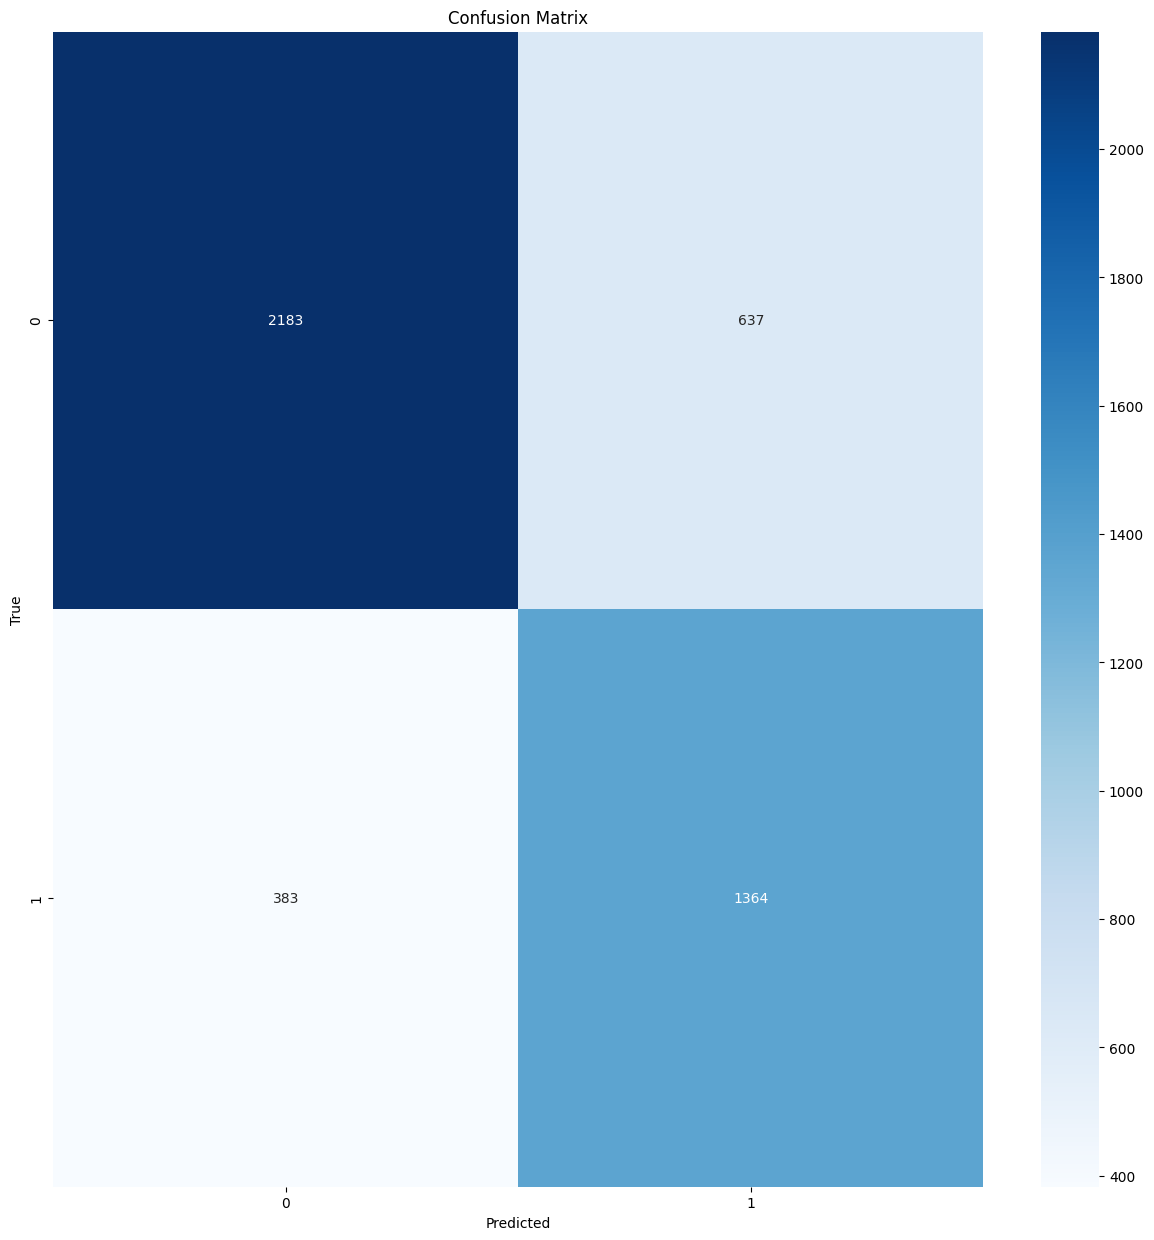

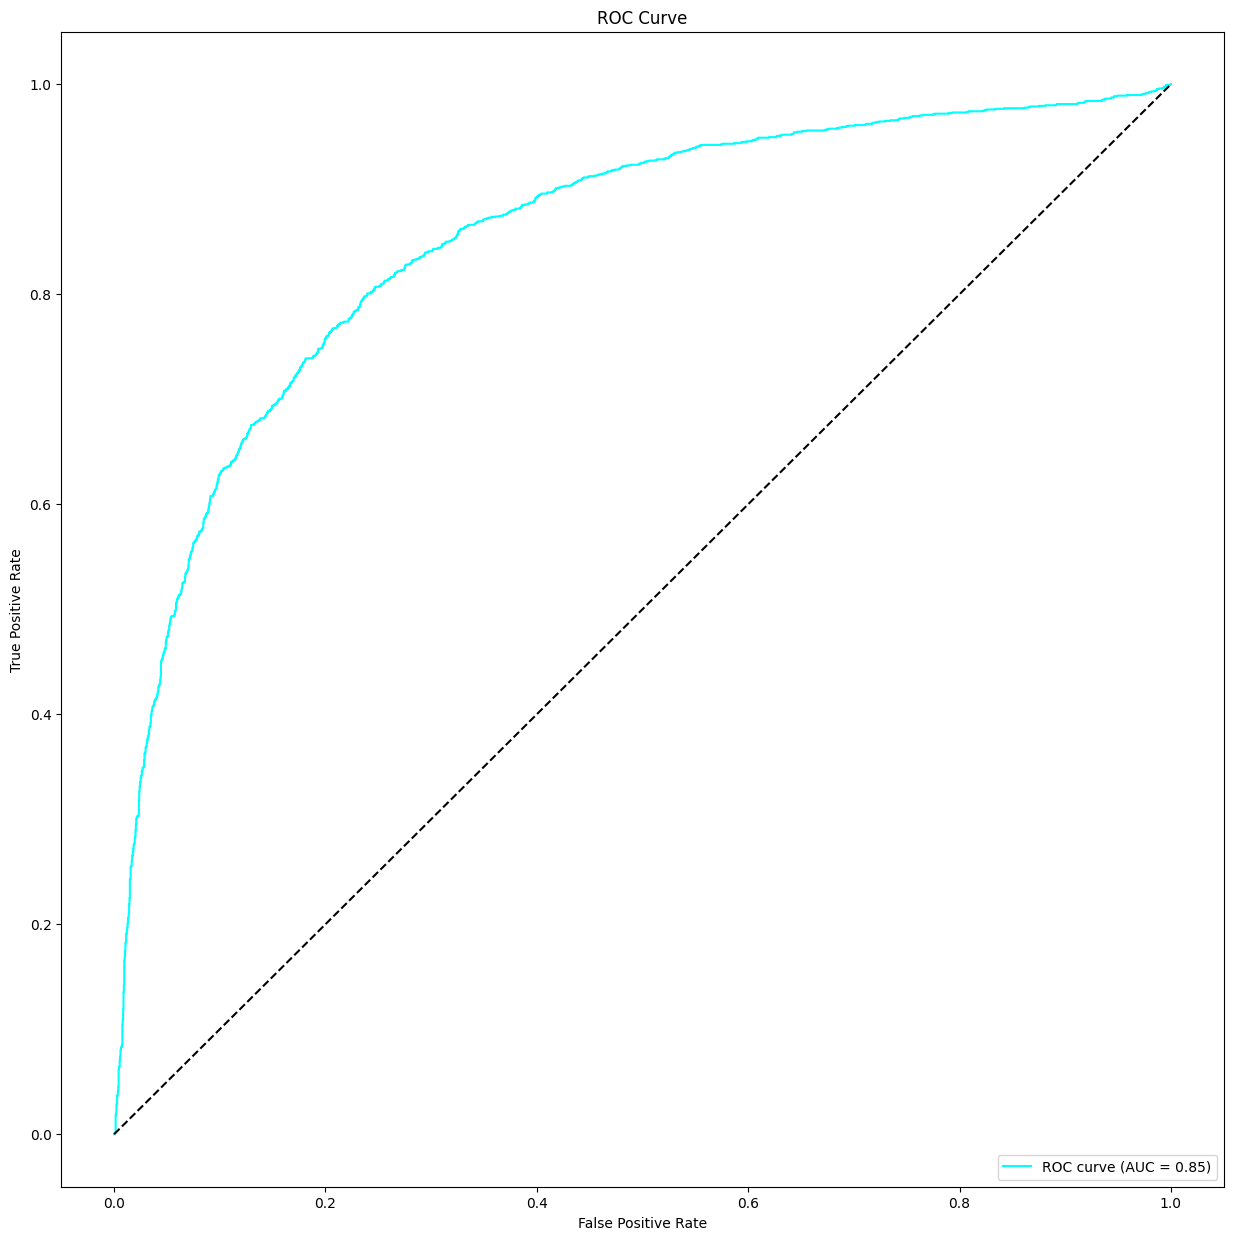

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      2820
           1       0.68      0.78      0.73      1747

    accuracy                           0.78      4567
   macro avg       0.77      0.78      0.77      4567
weighted avg       0.79      0.78      0.78      4567

##################################################  Saliency Maps  ##################################################

Class 0:


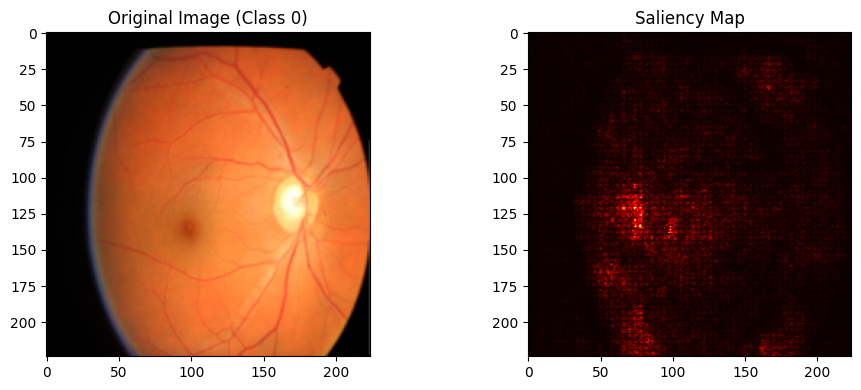

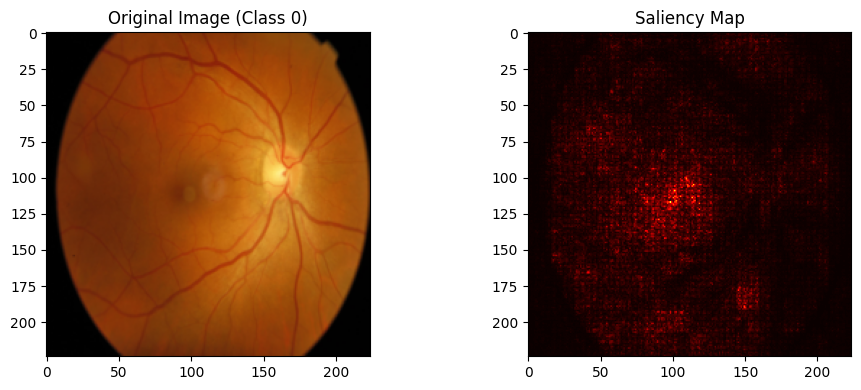

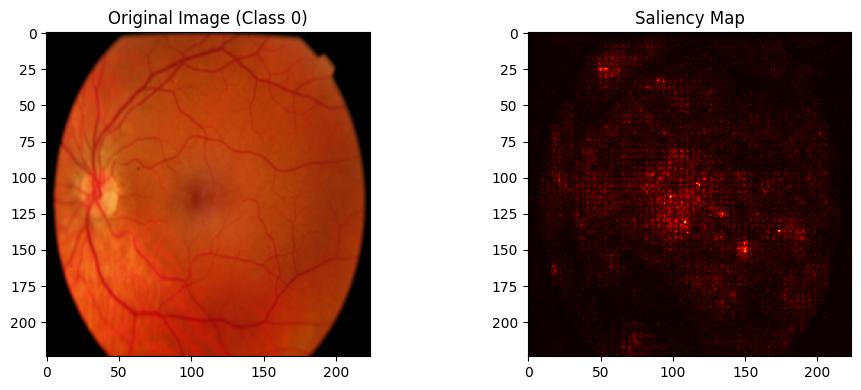

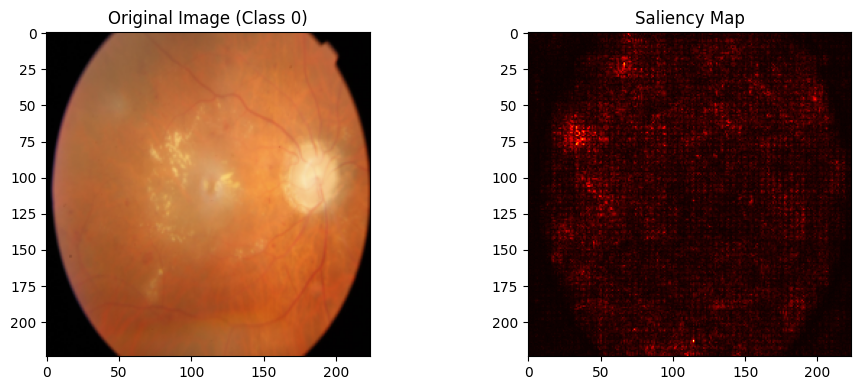

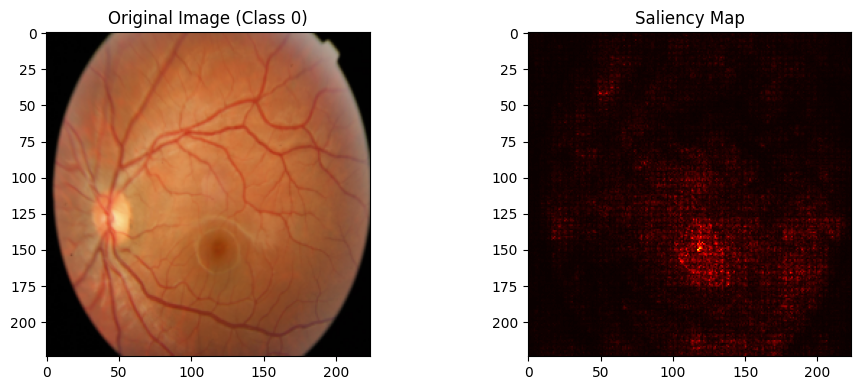

Class 1:


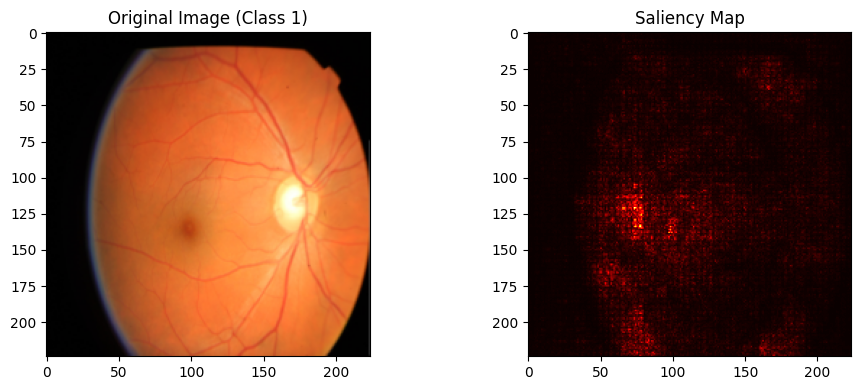

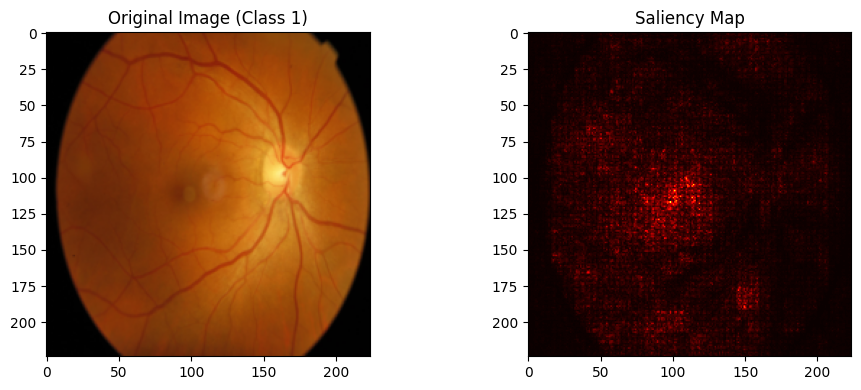

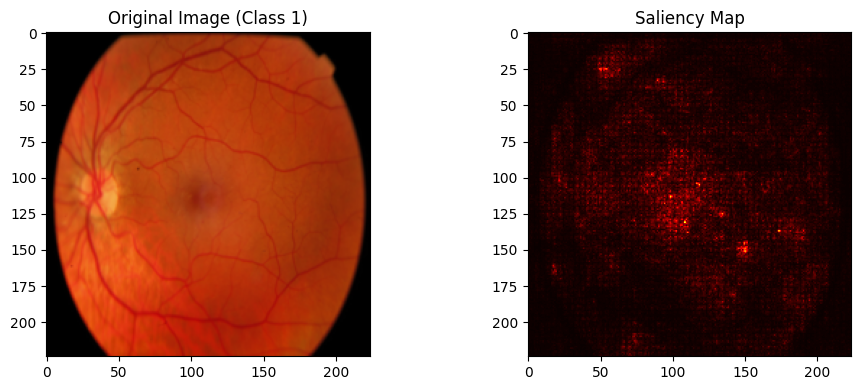

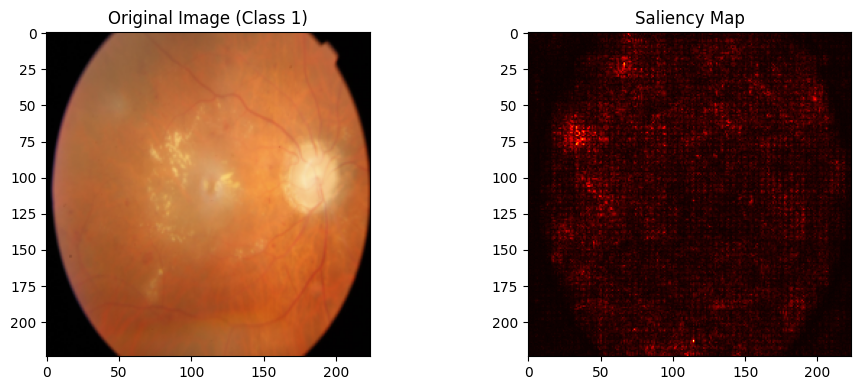

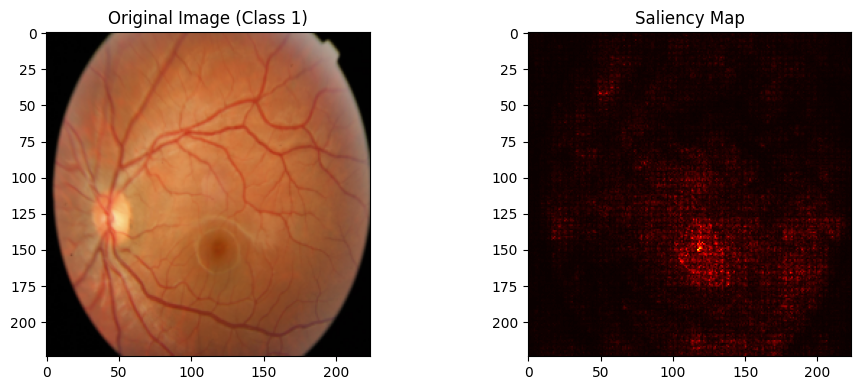

In [15]:
test(model, adequate_dataloader, saliency=True, device=device, save=True)

#### Inadequate image quality

100%|██████████| 40/40 [00:12<00:00,  3.31it/s]


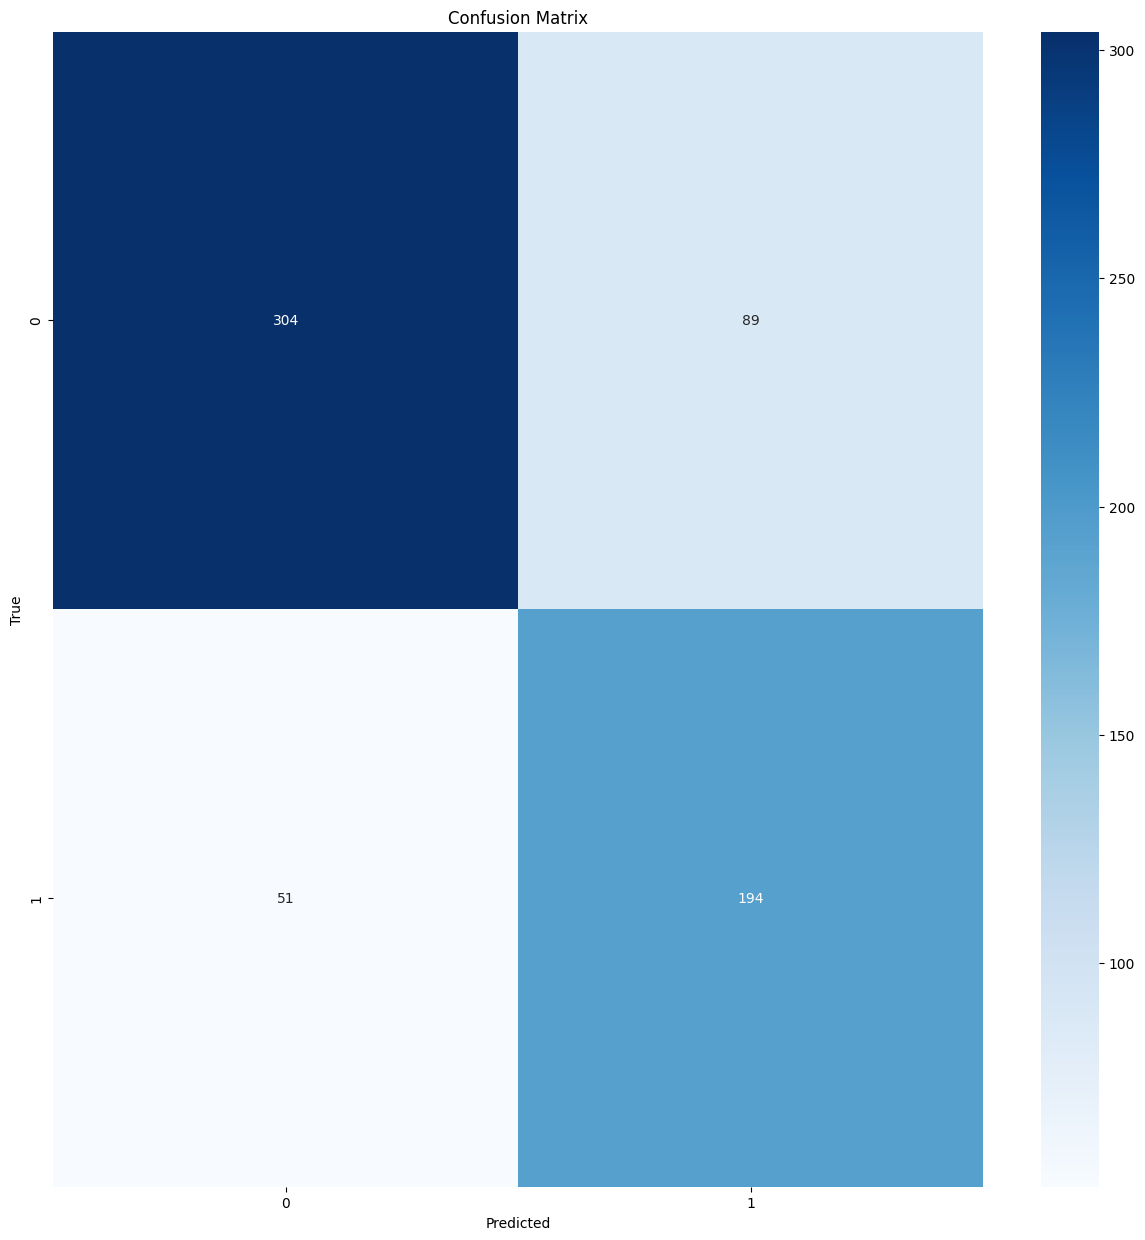

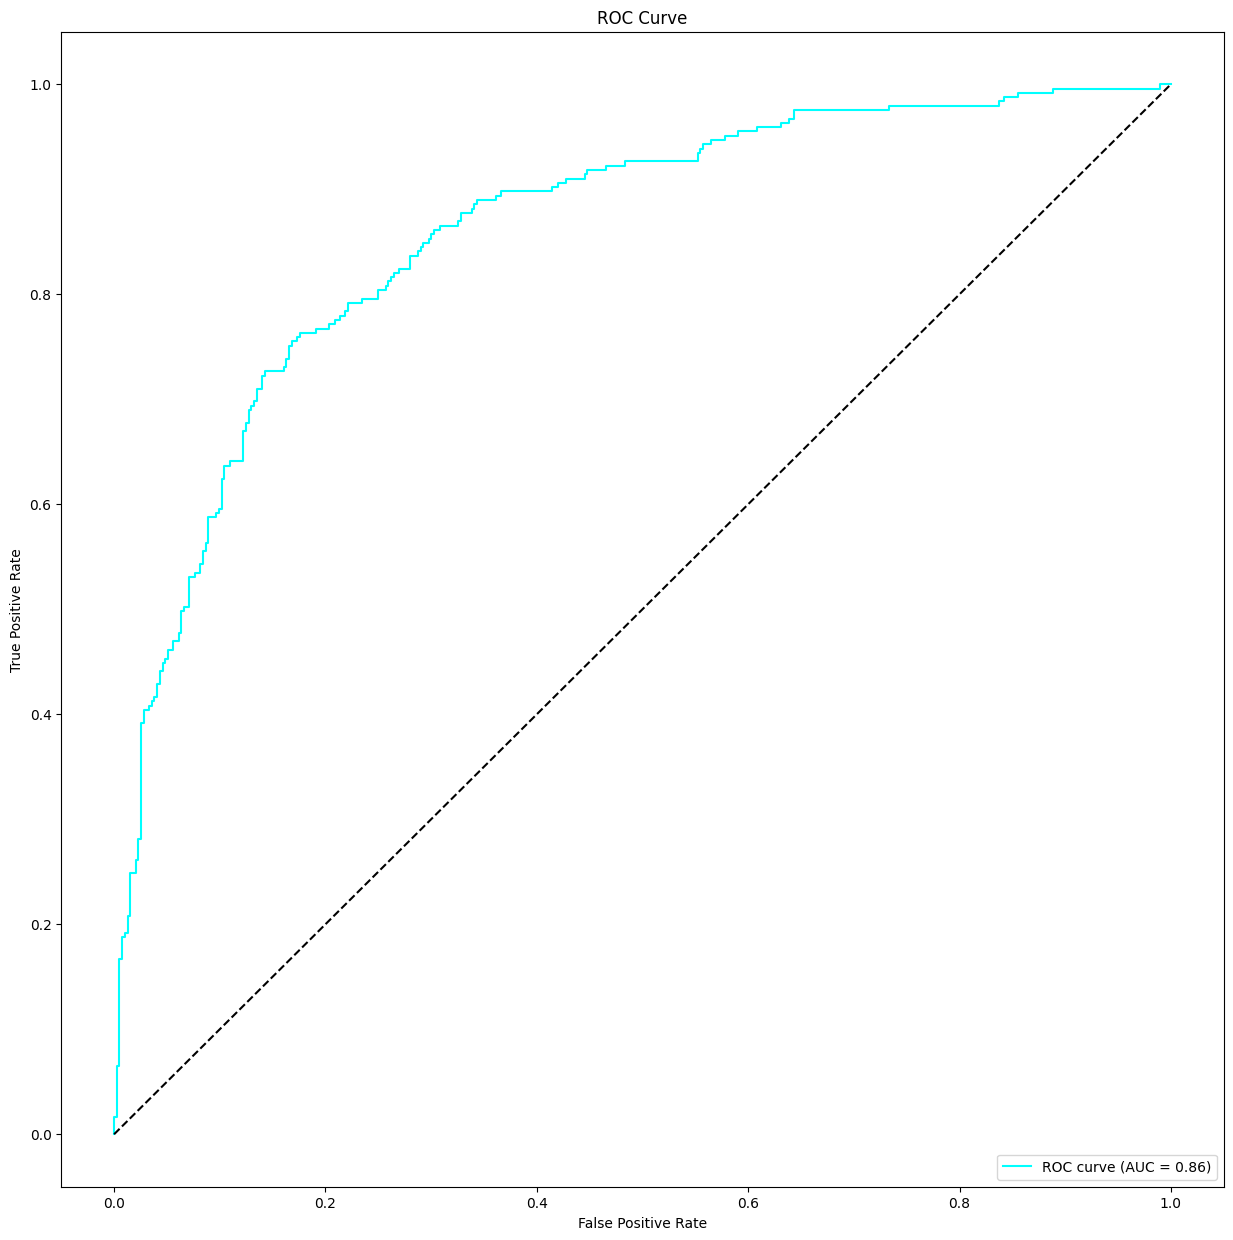

              precision    recall  f1-score   support

           0       0.86      0.77      0.81       393
           1       0.69      0.79      0.73       245

    accuracy                           0.78       638
   macro avg       0.77      0.78      0.77       638
weighted avg       0.79      0.78      0.78       638

##################################################  Saliency Maps  ##################################################

Class 0:


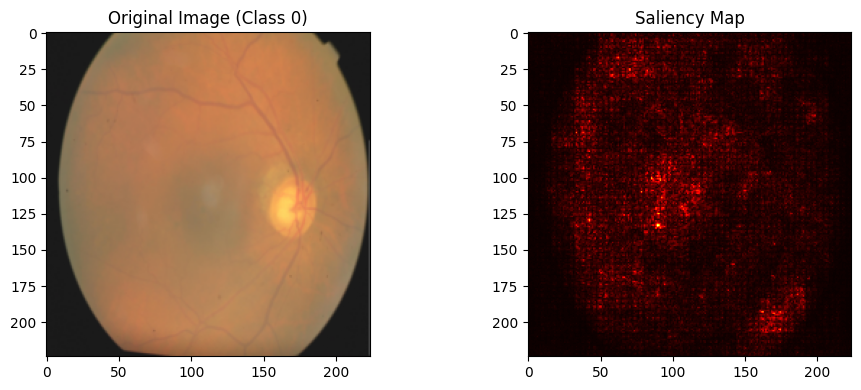

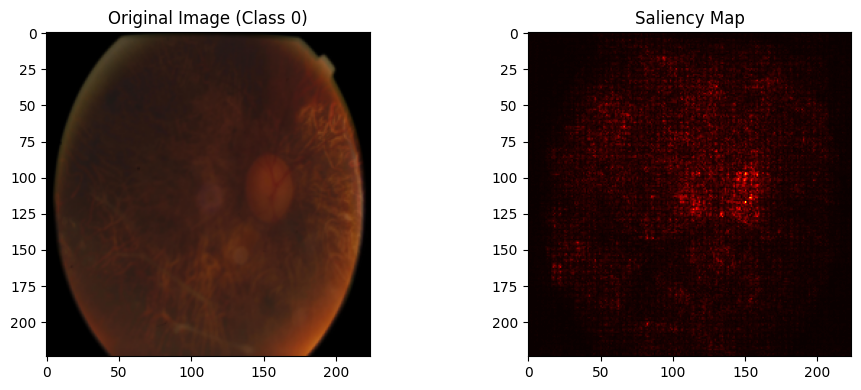

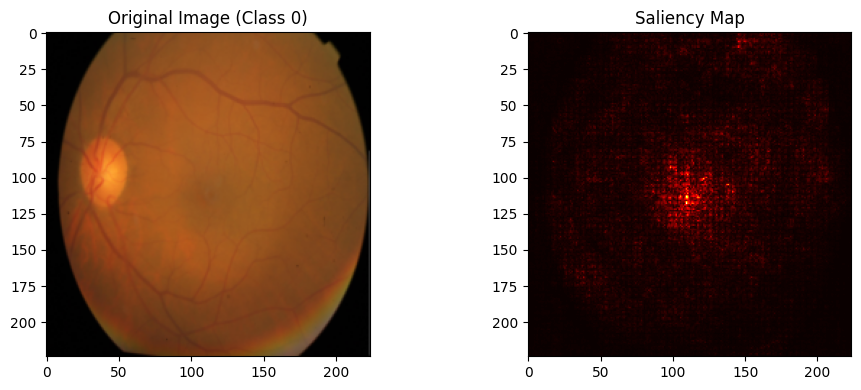

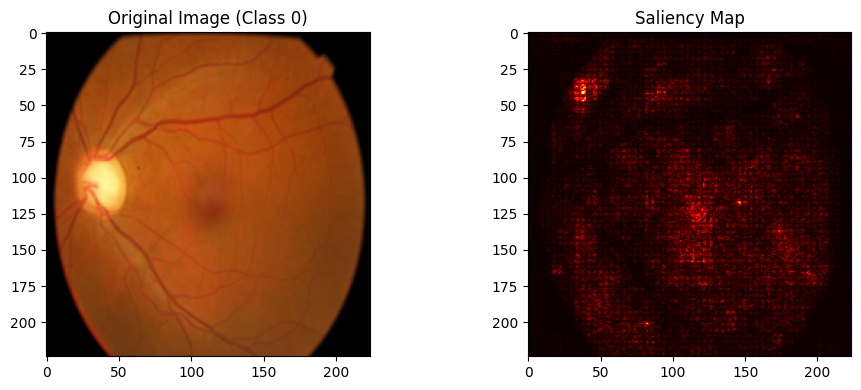

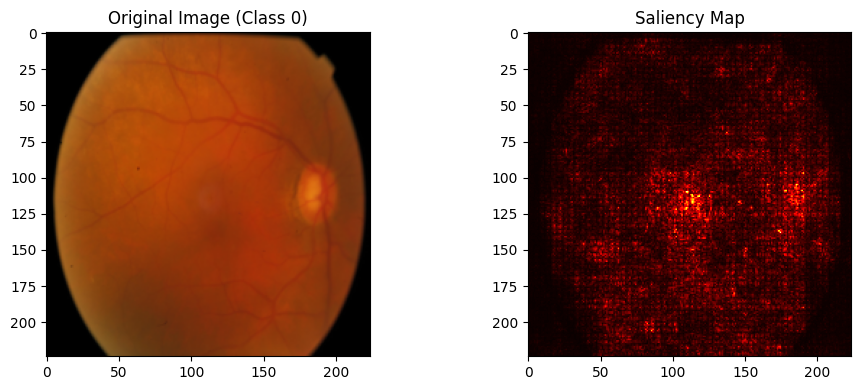

Class 1:


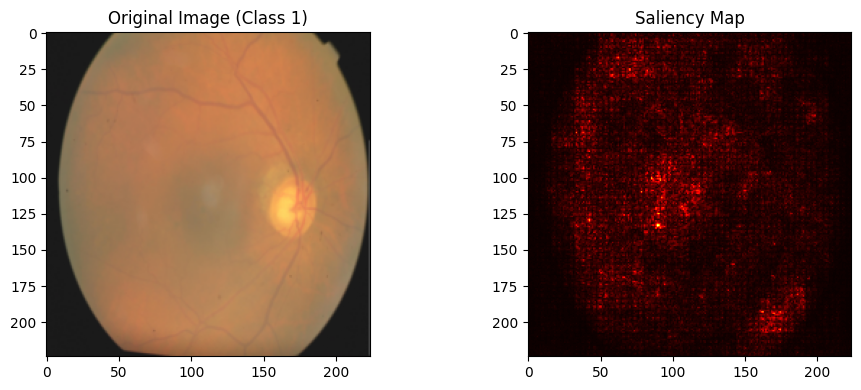

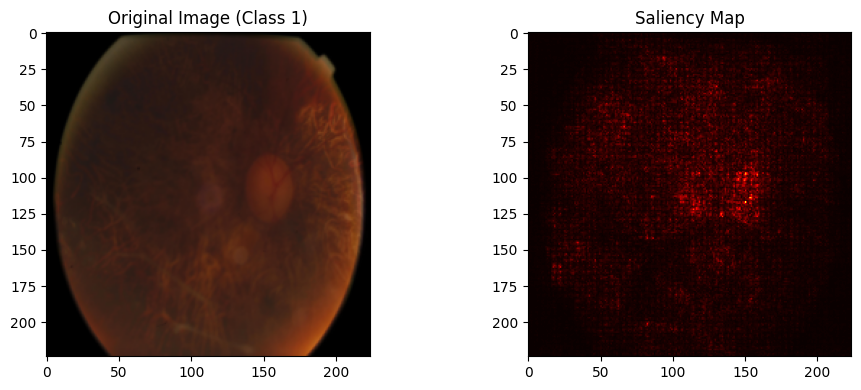

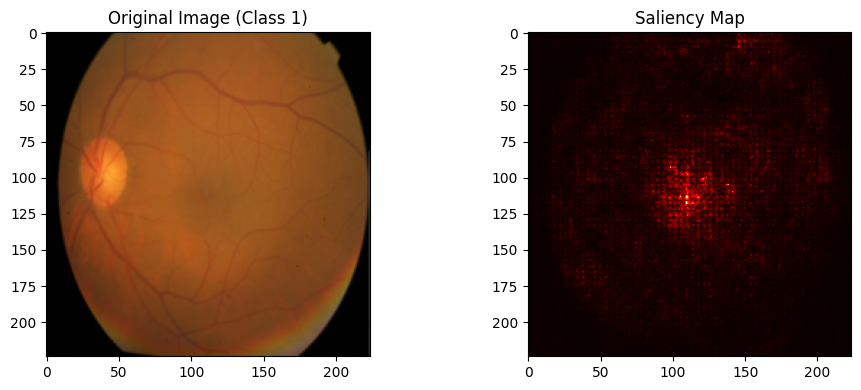

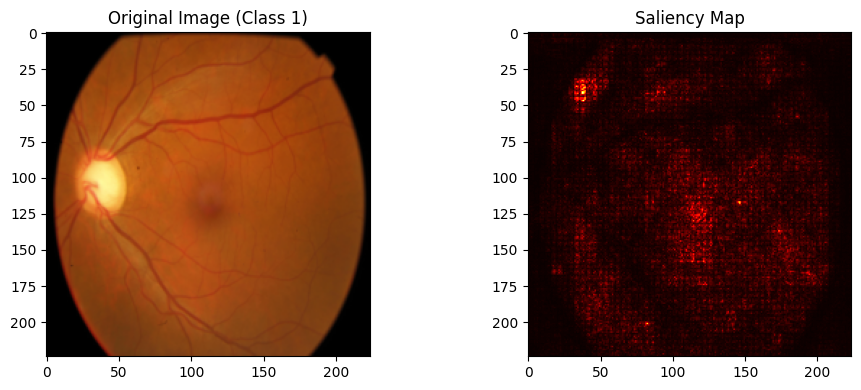

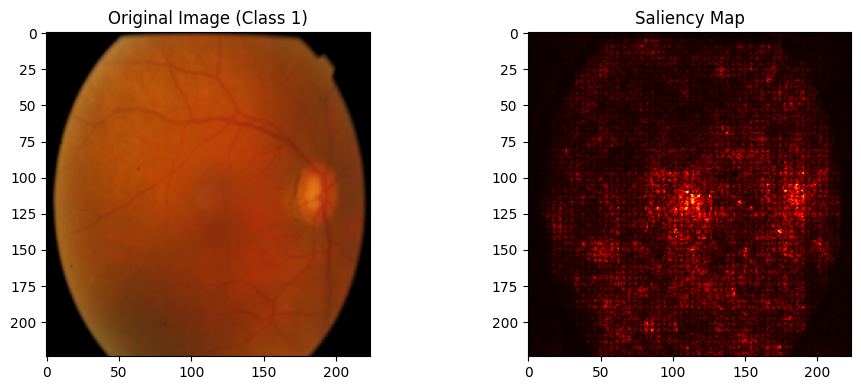

In [16]:
test(model, inadequate_dataloader, saliency=True, device=device)